In [2]:
import pandas as pd

# --- Load and clean ---
df = pd.read_csv("feat_dataset_filtered_with_weeks.csv")
df.columns = df.columns.str.replace(' ', '_')

# --- Define your activity columns ---
activity_cols = [
    'sleep_start',
    'sleep_end',
    'sleep_duration'
]

# --- Keep only columns that exist ---
activity_cols = [c for c in activity_cols if c in df.columns]

# --- Compute per-participant averages for Weeks 1, 6, 7, 8 ---
per_uid_week = (
    df[df['week_per_uid'].isin([1, 6, 7, 8])]
    .groupby(['uid', 'week_per_uid'])[activity_cols]
    .mean(numeric_only=True)
    .reset_index()
)

# --- Pivot to wide: one row per uid, columns = feature_w{week} ---
pivot = per_uid_week.pivot(index='uid', columns='week_per_uid', values=activity_cols)
pivot.columns = [f"{col}_w{wk}" for (col, wk) in pivot.columns]
pivot = pivot.reset_index()

# --- Save the raw week averages ---
pivot.to_csv("sleep_avgfeat.csv", index=False)

# --- Compute percent change for each feature ---
change_df = pd.DataFrame()
change_df['uid'] = pivot['uid']

for col in activity_cols:
    col_w1 = f"{col}_w1"
    col_w6 = f"{col}_w6"
    col_w7 = f"{col}_w7"
    col_w8 = f"{col}_w8"

    # Contextual: Week 6 vs Week 1
    if col_w1 in pivot.columns and col_w6 in pivot.columns:
        base = pivot[col_w1].replace(0, pd.NA)
        change_df[f"{col}_pct_change_cntx"] = (pivot[col_w6] - pivot[col_w1]) / base * 100

    # Generic: Week 8 vs Week 7
    if col_w7 in pivot.columns and col_w8 in pivot.columns:
        base = pivot[col_w7].replace(0, pd.NA)
        change_df[f"{col}_pct_change_generic"] = (pivot[col_w8] - pivot[col_w7]) / base * 100

# --- Save both contextual + generic percent changes ---
change_df.to_csv("sleep_pctchange_cntx_generic.csv", index=False)

/var/folders/r1/_8ps3x2x6nb6r77rz8dp80sh0000gn/T/ipykernel_26336/4048407643.py:4: DtypeWarning: Columns (427) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("feat_dataset_filtered_with_weeks.csv")


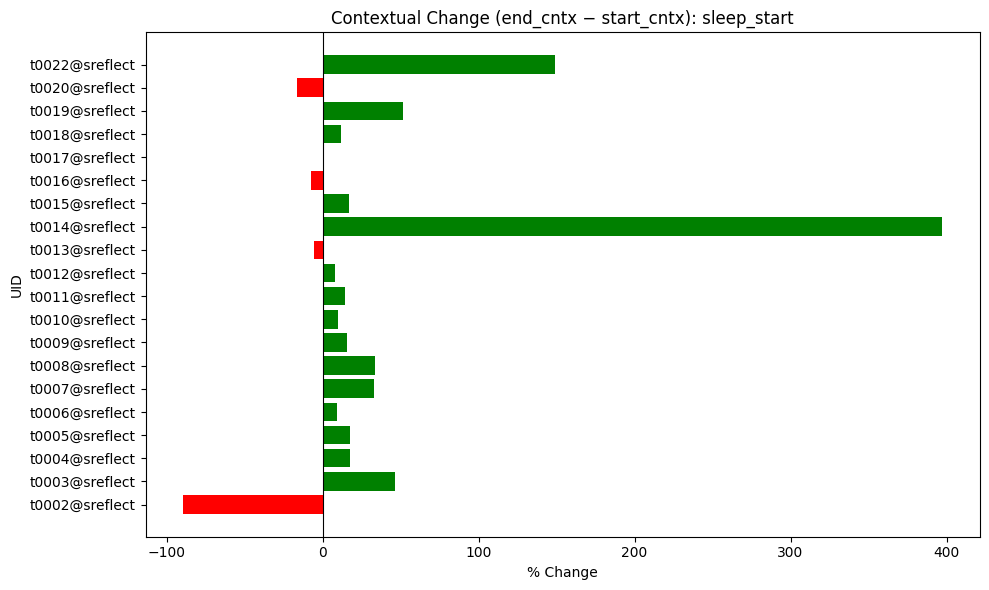

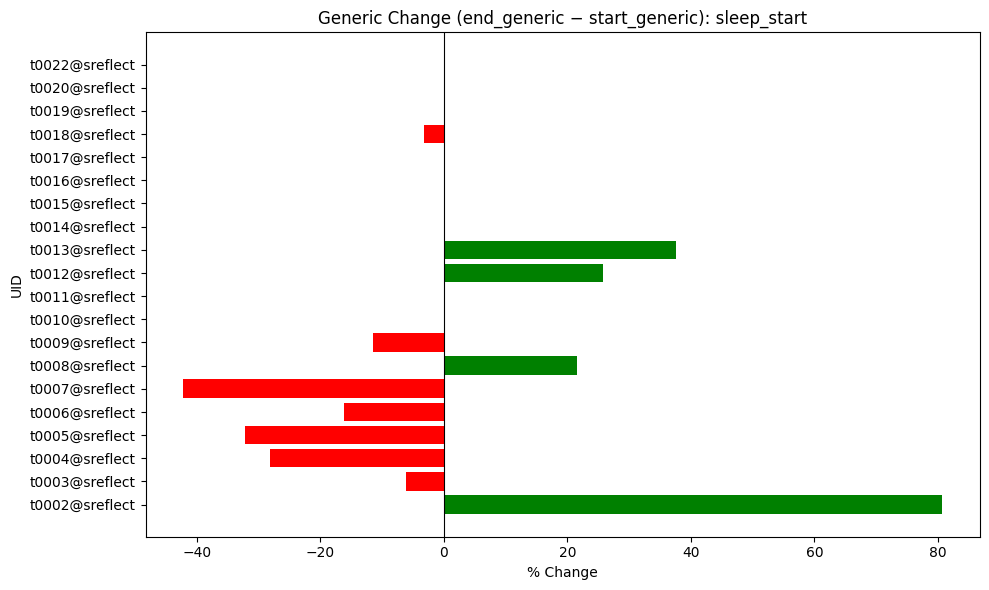

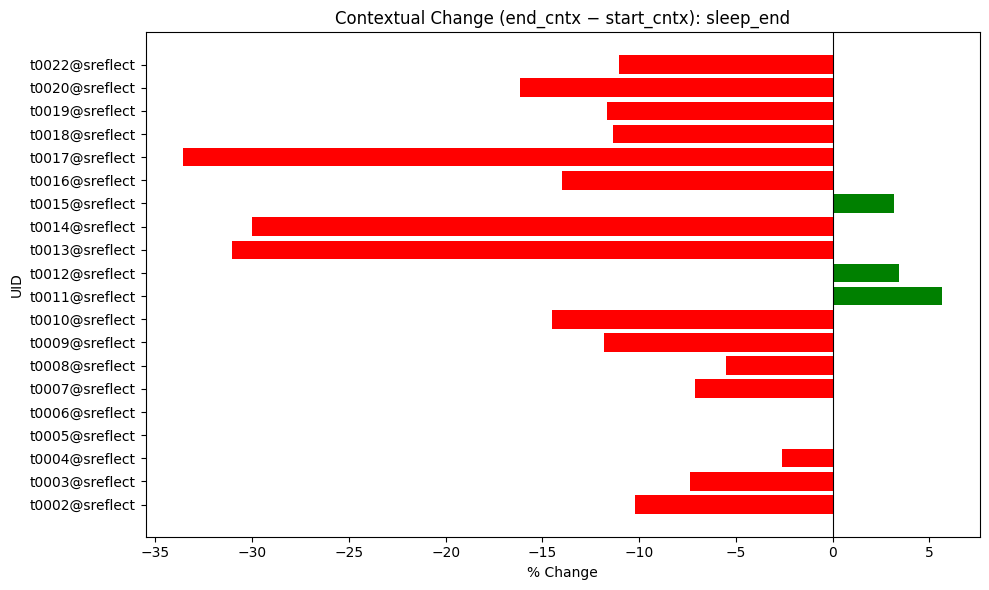

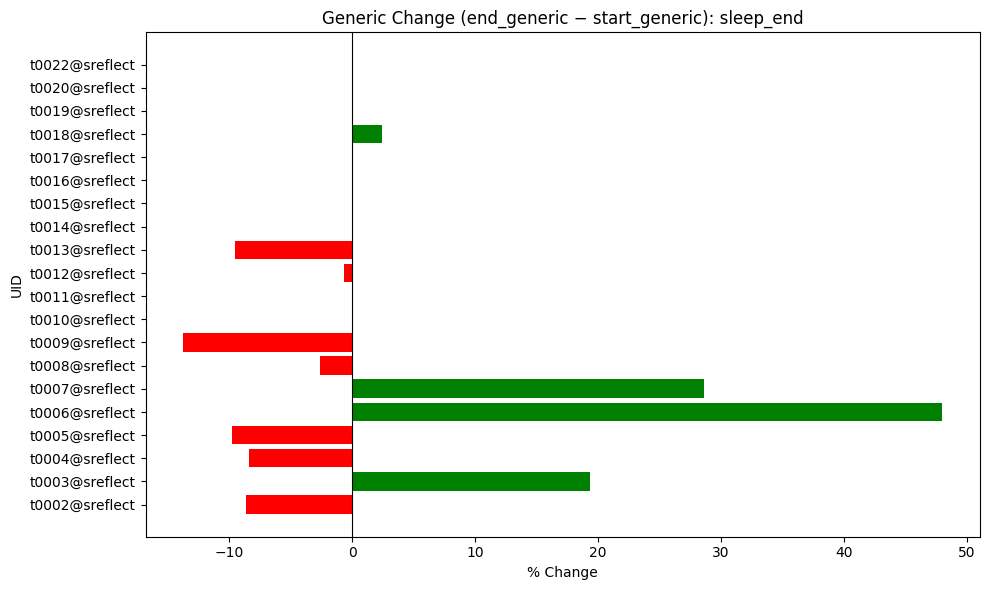

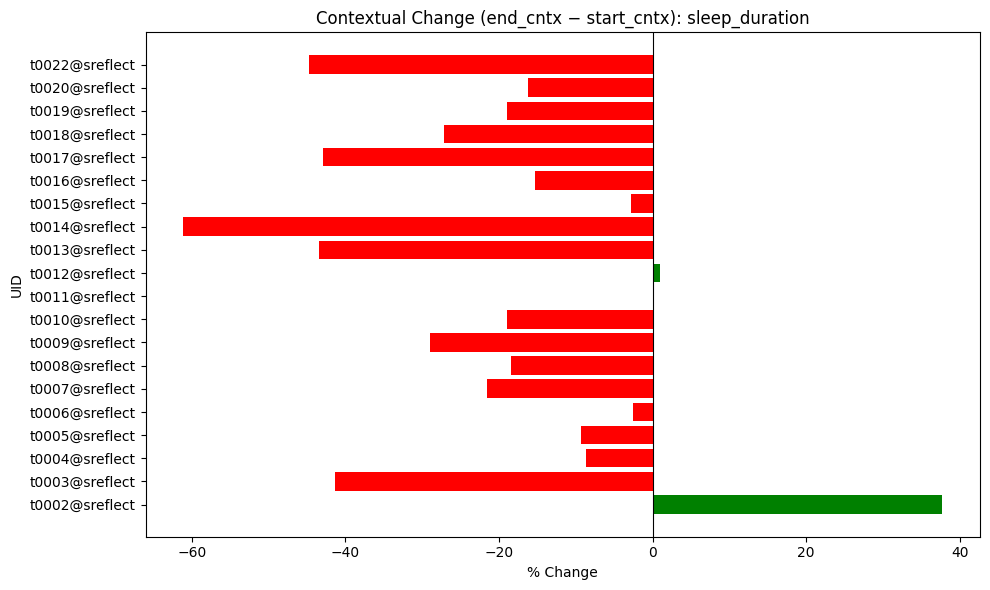

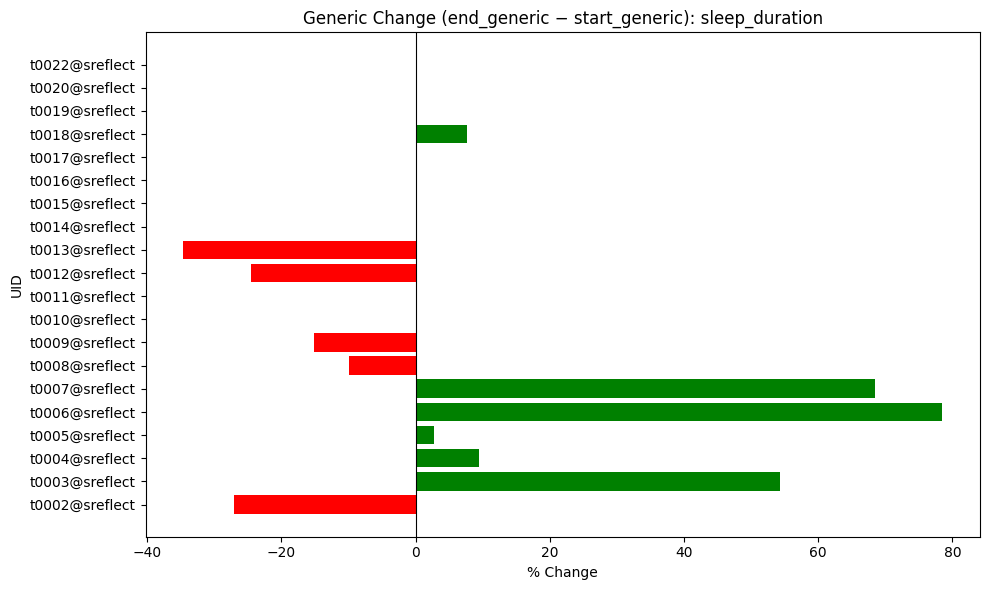

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("sleep_pctchange_cntx_generic.csv")

# Make uid the index for plotting
if 'uid' in df.columns:
    df = df.set_index('uid')

features = ["sleep_start", "sleep_end", "sleep_duration"]


for feature in features:

    # Column names for this feature
    col_cntx = f"{feature}_pct_change_cntx"
    col_generic = f"{feature}_pct_change_generic"

    # Check if columns exist (just in case)
    if col_cntx not in df.columns:
        print(f"Missing contextual column for {feature}")
        continue
    if col_generic not in df.columns:
        print(f"Missing generic column for {feature}")
        continue

    # ----------- CONTEXTUAL WEEK (W6 - W1) -----------
    vals_cntx = df[col_cntx].fillna(0)

    plt.figure(figsize=(10, 6))
    plt.barh(
        df.index,
        vals_cntx,
        color=vals_cntx.apply(lambda x: "green" if x > 0 else "red")
    )
    plt.axvline(0, color="black", lw=0.8)
    plt.title(f"Contextual Change (end_cntx − start_cntx): {feature}")
    plt.xlabel("% Change")
    plt.ylabel("UID")
    plt.tight_layout()
    plt.show()

    # ----------- GENERIC WEEK (W8 - W7) -----------
    vals_generic = df[col_generic].fillna(0)

    plt.figure(figsize=(10, 6))
    plt.barh(
        df.index,
        vals_generic,
        color=vals_generic.apply(lambda x: "green" if x > 0 else "red")
    )
    plt.axvline(0, color="black", lw=0.8)
    plt.title(f"Generic Change (end_generic − start_generic): {feature}")
    plt.xlabel("% Change")
    plt.ylabel("UID")
    plt.tight_layout()
    plt.show()
